# Movimiento del péndulo con ángulos pequeños
Los ángulos pequeños que usaremos para este movimiento se calcularon en el archivo "Ángulos Pequeños.ipynb", en este mismo directorio.

In [8]:
#Importamos las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd

#Importamos el rango de valores que consideramos pequeños
%store -r theta_peq

## Simulación Teórica

In [9]:
#Ingresamos los parámetros iniciales para la simulación
l = 2*u.m           #Longitud de la cuerda
th =3*u.deg     #Ángulo inicial (amplitud) del movimiento
g = 9.8*u.m/u.s**2  #Aceleración de la gravedad
m = 600*u.g         #Masa del cuerpo oscilador (la especificamos pero, al ser angulos pequeños, no la usamos)

In [87]:
def simTeoPeq (lon, ang, gra=9.8*u.m/u.s**2, per=1):
    
    """
    Esta función genera una simulación teórica del movimiento de un
    pendulo ingresandole algunos parámetros iniciales. Analiza si
    el ángulo inicial ingresado se encuentra en el rango de ángulos
    cuyo sen(ángulo) es aproximado al mismo ángulo. Todos los valores
    ingresados (a excepción de per) deben tener sus respectivas unidades
    para que no salte un error.
    
    Params:
    lon:
        Longitud de la cuerda. Debe estár en unidades de longitud.
    ang:
        Ángulo inicial del movimiento. Debe estar en unidades angulares.
    gra:
        Aceleración de gravedad. Debe estar en unidades de aceleración.
        Por defecto se usa 9.8m/s^2, pues es el estándar para la tierra.
    per:
        Los periodos o "vueltas" que se quiere simular. Cabe resaltar que
        No va a cambiar mucho entre periodos pues estamos despreciando
        la fricción con el aire. No debe tener unidades. Por defecto: 1.
    
    Returns:
        No hay returns, se imprimen los valores de periodo y velocidad
        angular, así como las gráficas de posición angular, velocidad
        angular y aceleración angular en función del tiempo.
    """
    
    if theta_peq[0]>ang.to("rad").value or ang.to("rad").value>theta_peq[-1]:
        return print("El ángulo está fuera del rango de ángulos considerados pequeños: [",
                     theta_peq[0], ",", theta_peq[-1],"] rad", sep = "")
    
    #Calculamos el periodo, teniendo encuenta que estamos en una aproximación para ángulos pequeños
    T = (2*np.pi*np.sqrt(lon/gra)).to("s")
    print("El periodo del movimiento es T =", round(T.value, ndigits=2)*T.unit)
    
    #Generamos valores de tiempo entre 0 y el periodo del movimiento
    t = np.linspace(0,per*T, 100)

    #Luego, la frecuencia angular para ángulos pequeños
    w = ((2*np.pi)*u.rad/T)
    print("La frecuencia angular del movimiento es w =", round(w.value, ndigits=1)*w.unit)    

    #Ahora, los angulos para cada instante t de tiempo
    angs = (ang.to("rad")*np.cos(w*t))
    
    #Hallamos la velocidad angular (la derivada del tiempo)
    vel = -(ang.to("rad")*w*np.sin(w*t))
    
    #La aceleración angular para ángulos pequeños (solo tomamos en cuenta su magnitud)
    a = (-(gra/lon)*angs.to("rad"))
    
    #Iniciamos la generación de los gráficos
    #Primero la posición angular
    plt.plot(t, angs.to("deg"), color="purple")
    plt.xlabel(r"$Tiempo(s)$", size=13)
    plt.ylabel(r"$\theta(°)$", size=13)
    plt.axhline(0, color="k", alpha=0.5)
    plt.xlim([0,t[-1].value])
    plt.title("Posición angular respecto al tiempo", size=14, fontstyle="oblique")
    plt.grid(alpha=0.5)
    plt.show()
    
    #Ahora velocidad angular
    plt.plot(t, vel, color="purple")
    plt.xlabel(r"$Tiempo(s)$", size=13)
    plt.ylabel(r"$\dot{\theta}(\frac{°}{s})$", size=13)
    plt.axhline(0, color="k", alpha=0.5)
    plt.xlim([0,t[-1].value])
    plt.title("Velocidad angular respecto al tiempo", size=14, fontstyle="oblique")
    plt.grid(alpha=0.5)
    plt.show()
    
    #Por último, aceleración angular
    plt.plot(t, a, color="purple")
    plt.xlabel(r"$Tiempo(s)$", size=13)
    plt.ylabel(r"$\ddot{\theta}(\frac{°}{s^2})$", size=13)
    plt.axhline(0, color="k", alpha=0.5)
    plt.xlim([0,t[-1].value])
    plt.title("Aceleración angular respecto al tiempo", size=14, fontstyle="oblique")
    plt.grid(alpha=0.5)
    plt.show()

El periodo del movimiento es T = 2.84 s
La frecuencia angular del movimiento es w = 2.2 rad / s


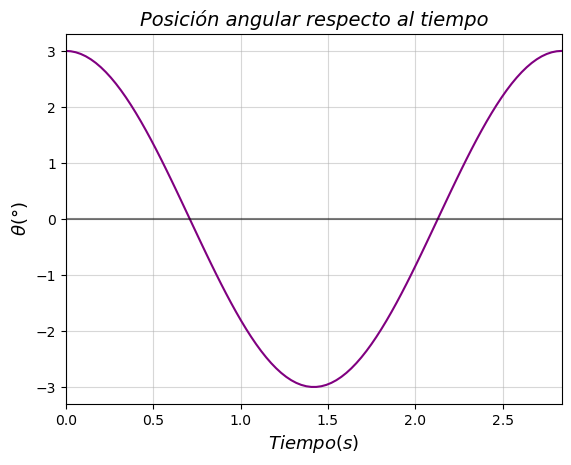

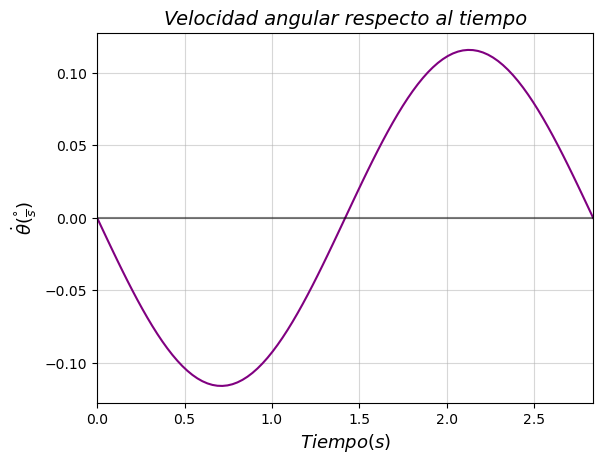

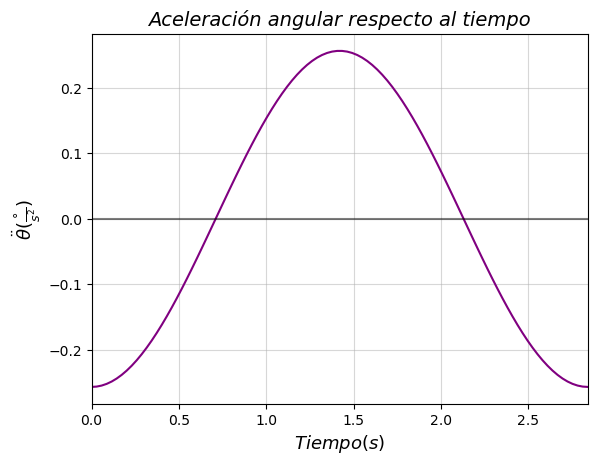

In [88]:
simTeoPeq(l, th, g)

## Análisis de los datos experimentales

In [41]:
for i in range(1,11):
    datos_theta = pd.DataFrame()
    locals()["datos_" + str(i)] = pd.read_csv("../Datos/Cuerda 1m/3grados_1m300ml/"+str(i)+"_3grad1m300ml.csv",
                                  skiprows=2,
                                  index_col=False,
                                  sep=".",
                                  names=("t","theta"),
                                  converters={"theta" : lambda x: ((float(x[0:-1].replace(',','.')))+90)*-1,
                                              "t" : lambda y: (round(float(y.replace(",",".")), ndigits = 2))}
                                  )
    datos_theta["tetha_" + str(i)] = locals()["datos_" + str(i)].theta

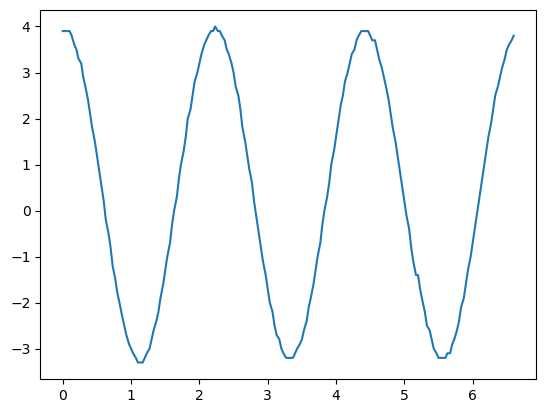

In [93]:
plt.plot(datos_1.t,datos_1.theta)
plt.show()

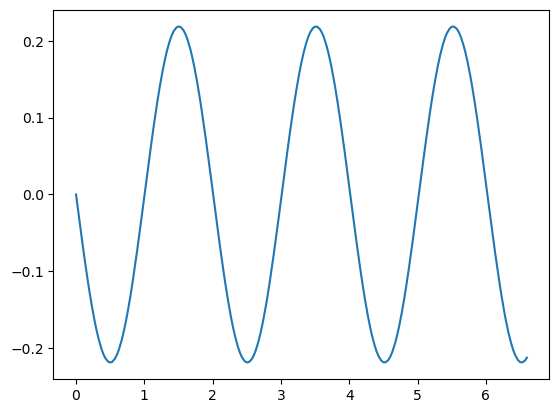

In [100]:
plt.figure()
plt.plot(datos_1.t, -((datos_1.theta.max()*np.pi/180)*(np.sqrt(9.8))*np.sin(np.sqrt(9.8)*datos_1.t)))
plt.show()

In [14]:
#Aceleración en función del periodo
g_x = (4*np.pi**2*l)/T**2

NameError: name 'T' is not defined